



# LSTM-MSNet Implementation

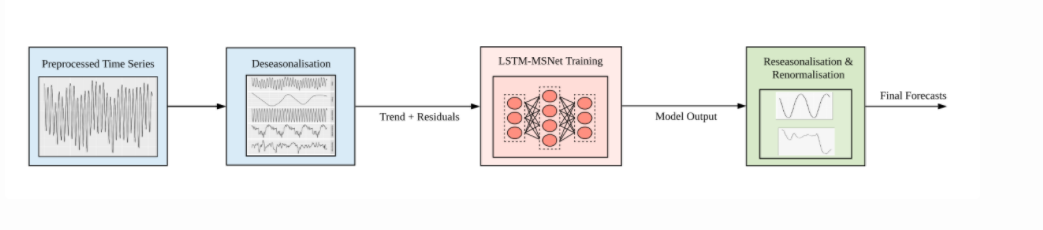


https://greendeck.slite.com/p/note/Qdcr1wNK9Ew6gYPPLmNLfZ

https://arxiv.org/pdf/1909.04293.pdf

# Introduction

* Time series forecasting is enabling modern day business planning by landscaping the short-term,medium-term and long-term goals in an organisation. As such, generating accurate and reliable forecasts is, leading to savings and cost reductions. 

* The complex nature of the properties present in a time series, such as seasonality, trend, and level, may bring numerous challenges to produce accurate forecasts. In terms of seasonality, a time series may
exhibit complex behaviour such as multiple seasonal patterns( such as daily ,weekly, yearly etc.), non-integer seasonality, calendar effects, etc.




    


 



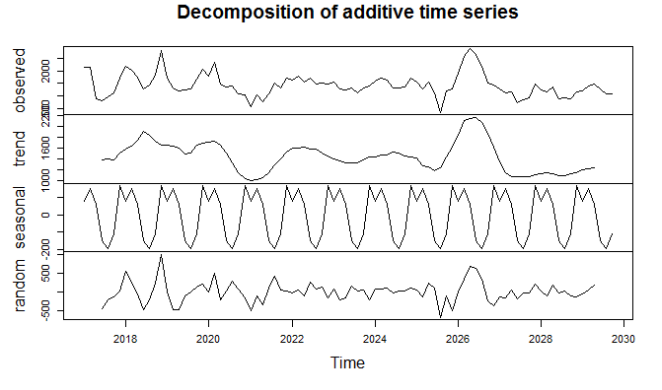


* The current methods to handle multiple seasonal patterns
are mostly statistical forecasting techniqus that are
univariate. Thus, they treat each time series as an independent
sequence of observations, and forecast it in isolation.


*  The univariate time series forecasting is not able to exploit any
cross series information available in a set of time series that
may be correlated and share a large amount of common feature.

 Examples for these are sales demand of related
product assortments in retail, server performance measures in
computer centres, household smart meter data, etc. This can
be applied to the time series shown in Fig. , in which these
energy consumption patterns of various households can be
similar and may share key properties in common.


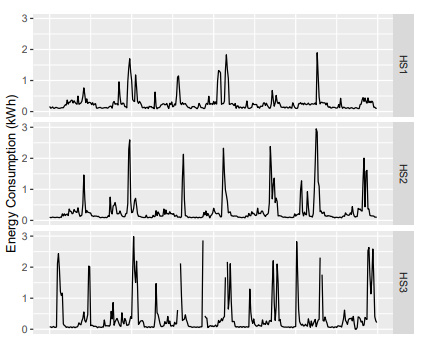

* Generating forecasts for time series with multiple
seasonal cycles is an important use-case for many industries
nowadays.

* The current state of the art in this
space are typically univariate methods, in which the model
parameters of each time series are estimated independently.
Consequently, these models are unable to include key patterns
and structures that may be shared by a collection of time series.

* In contrast, LSTM-MSNet is a globally trained Long Short-Term
Memory network (LSTM), where a single prediction model is
built across all the available time series to exploit the crossseries knowledge in a group of related time series. Furthermore,
this methodology combines a series of state-of-the-art multiseasonal decomposition techniques to supplement the LSTM
learning procedure.


*  The architecture of LSTM-MSNet is a fusion of statistical decomposition
techniques and recurrent neural networks. The LSTM-MSNet
has three layers, namely:
 
* the pre-processing layer, which consists of a normalisation and variance stabilising phase, and
a seasonal decomposition phase, 
*  the recurrent layer, which
consists of an LSTM based stacking architecture to train the
network, and 
*  a post-processing layer to denormalise and
reseasonalise the time series to derive the final forecasts. The
proposed framework can be used with any RNN variants(LSTM , GRU).

## Imports

In [ ]:
import torch
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from fbprophet import Prophet
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")

In [ ]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')


## Data Loading and Preprocessing

In [ ]:
# Mount Google Drive to access stored data
from google.colab import drive
drive.mount('/content/drive')

In [ ]:

def load_data(path, no_of_rows):
  data = pd.read_csv(path , encoding = 'UTF-8' , index_col= False)
  # Transpose Dataframe
  data = data.T
  # Reset index
  data.reset_index(drop=True, inplace = True)
  # Convert first row as Headers
  headers = data.iloc[0]
  # Selected first 700 rows, as per the paper
  data  = pd.DataFrame(data.values[1:no_of_rows +1], columns=headers)
  return data


In [ ]:
#https://www.kaggle.com/yogesh94/m4-forecasting-competition-dataset?select=Hourly-train.csv
data = load_data("/content/drive/My Drive/Hourly-train.csv",700)

In [ ]:
data.shape


(700, 414)

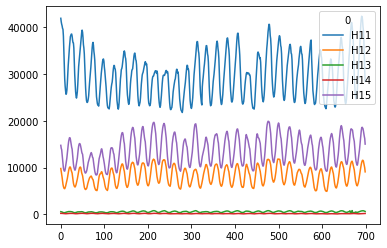

In [ ]:
# Plotting time series instances to check various components present
data.iloc[:,10:15].plot();

# Layer 1 : Normalisation and Variance Stabilisation Layer

*  As in a collection of time series, each time series may contain observations with different value ranges, performing a data normalisation strategy becomes necessary. Hence, we use the mean-scale
transformation strategy, which uses the mean of a time series
as the scaling factor. 

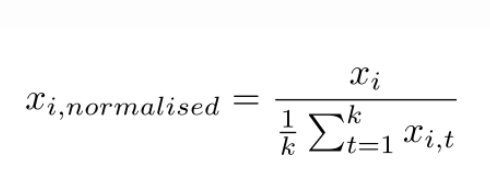

  Here, xi,normalised represents the normalised observation,
and k represents the number of observations of time series i

In [ ]:
def Normalization(data):
  '''
  Function to normalize dataframe by deviding each time series(column) with it's mean.
  '''
  return data.div(data.sum(axis=0)/data.shape[0], axis=1)


* After normalising the time series, we stabilise the variance
in the group of time series by transforming each time series
to a logarithmic scale.

* Apart from the variance stabilisation,
the log transformation also enables the conversion of the seasonality form in a given time series to an additive form.
This is a necessary requirement for additive time series decomposition techniques employed in decomposition layer.

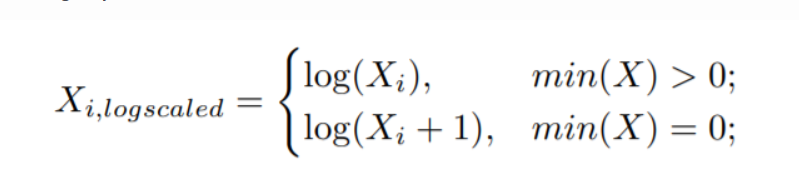

* Here, X denotes a time series, and Xi,logscaled is the
corresponding log transformed time series i.

In [ ]:

 
def log_transform(data):
  '''
  Function to transfrom time series to logarithmic scale
  '''
  return np.log(data)


In [ ]:
normalized_data = Normalization(data) 
log_transformed_data = log_transform(normalized_data.astype(np.float64))
log_transformed_data.shape


(700, 414)

Plotting Normalized and Variance Stablized Data 

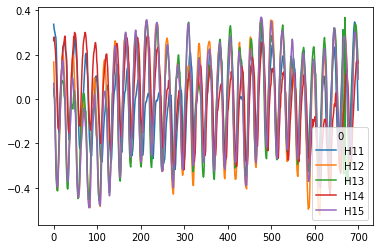

In [ ]:
log_transformed_data.iloc[:,10:15].plot()


MSNet introduces two training paradigms to accommodate
both homogeneous and inhomogeneous groups of time series

multiple seasonal patterns, exhibiting different levels of seasonal homogeneity.

# Layer 2: Seasonal Decomposition

* The complex nature
of the properties present in a time series, such as seasonality,
trend, and level, may bring numerous challenges to produce
accurate forecasts. In terms of seasonality, a time series may
exhibit complex behaviour such as multiple seasonal patterns,
non-integer seasonality, calendar effects, etc

*  When modelling seasonal time series with NNs, many studies suggest applying a prior seasonal adjustment, i.e., de-seasonalization to the time series. 

*  Here,
deseasonalisation refers to the process of removing the seasonal component from a time series

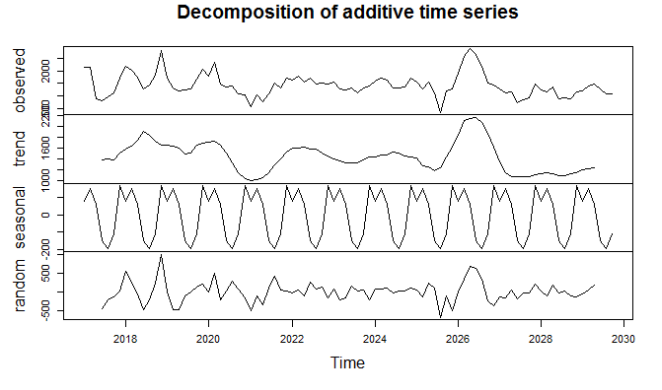




* The main intention of this approach is to minimize the complexity of the original time series by  detaching the multi-seasonal components from a time series, and thereby reducing the subsequent effort of the NN’s learning process. 
* Here, Multi-seasonal components refer to the repeating patterns that exist in a time series and that may change slowly over time

### Proposed Methods for Decomposition

1. Multiple STL Decomposition (MSTL)
2. Seasonal-Trend decomposition by Regression (STR)
3. Trigonometric, Box-Cox, ARMA, Trend, Seasonal
(TBATS)
4. Prophet
5. Fourier Transformation

* Here we are using **Prophet** among all for Decomposition.


## Prophet 

It is an automated forecasting framework
developed by Taylor and Letham . The main aim of this
framework is to address the challenges involved in forecasting
at Facebook, the employer of those authors at that time. The
challenges include the task of forecasting time series with
multiple seasonal cycles. 
*  Prophet
uses an **additive decomposition layer** and also introduces an additional term to model holidays as seasonal covariates. 




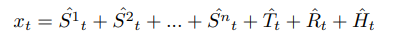

Here, xt represents the observation at time t, and Sˆ
t, Tˆ
t, Rˆ
t
refers to the seasonal, trend, and the remainder components of
the observation, n denotes the number of distinct seasonal patterns
decomposed, Hˆ
t denotes the holiday covariates in the model that
represent the effects of holidays respectively.

### Visualization of Decompostion

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


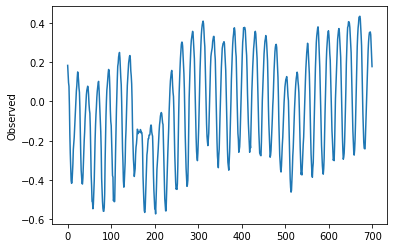

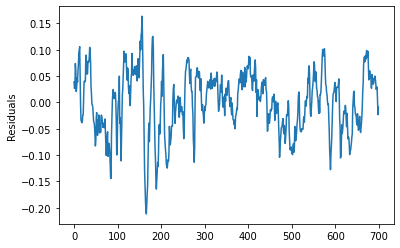

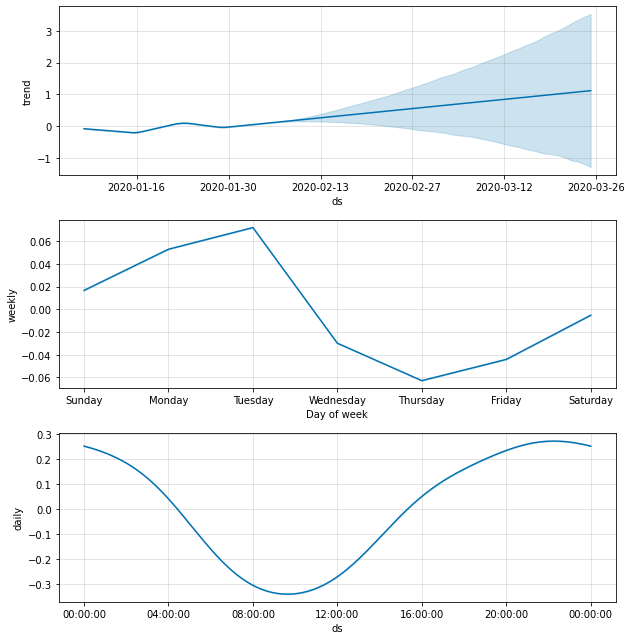

In [ ]:
time_series = log_transformed_data.iloc[:,1:2]
# Adding date time index
rng = pd.date_range('1/8/2020 00:00', periods=data.shape[0], freq='H')
time_series['ds'] = rng
time_series = time_series.rename(columns={ 'H2':'y'})
m = Prophet()
m.fit(time_series)
prediction = m.predict(m.make_future_dataframe(periods = 48))

residuals = time_series['y'] - prediction['yhat']

plt.plot(time_series.iloc[:,0]) 
plt.ylabel('Observed')
plt.show()
plt.plot(residuals)
plt.ylabel('Residuals')
plt.show()
m.plot_components(prediction); 

    
    

In [ ]:
def seasonal_decomposition(data):
  cols = data.columns
  # Adding date time index
  rng = pd.date_range('1/8/2020 00:00', periods= data.shape[0], freq='H')
  data['ds'] = rng
  deseasonalized_data = {}
  trend = {}
  seasonality = {}
  for col in cols:
    subdf = data[['ds', col]]
    subdf = subdf.rename(columns={ col:'y'})
    
    m = Prophet(seasonality_mode='additive', weekly_seasonality= True)
    print(col)
    m.fit(subdf)
    result = m.predict(m.make_future_dataframe(periods = 48 , freq = 'H'))
    
    
    trend[col] = result['trend']
    seasonality[col] = result['daily'] + result['weekly']
    deseasonalized_data[col] = result['trend'] + result['additive_terms'] + result['multiplicative_terms']
  trend_df = pd.DataFrame(trend)
  deseasonalized_df = pd.DataFrame(deseasonalized_data)
  seasonality_df = pd.DataFrame(seasonality) 
  return trend_df, deseasonalized_df,seasonality_df


In [ ]:
trend_df,deseasonalized_df,seasonality_df = seasonal_decomposition(log_transformed_data)

In [ ]:
deseasonalized_df.to_csv('/content/drive/My Drive/Colab Notebooks/deseasonalized_data.csv')
trend_df.to_csv('/content/drive/My Drive/Colab Notebooks/trend.csv')
seasonality_df.to_csv('/content/drive/My Drive/Colab Notebooks/seasonality.csv')


In [ ]:
# https://drive.google.com/file/d/1-2DQupgkZBOc51EX2q1tzTfrpB0s_DuK/view?usp=sharing
deseasonalized_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/deseasonalized_data.csv")
#https://drive.google.com/file/d/1UqErcdBXdq8oDWXFtQX88bSBLqYQ_SIt/view?usp=sharing
trend_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/trend.csv")
#https://drive.google.com/file/d/1wdS0-fZC6ULh3MtvTx4a0FMpDTmpH7f3/view?usp=sharing
seasonality_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/seasonality.csv")


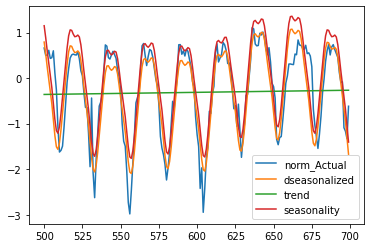

In [ ]:

plt.plot(log_transformed_data['H144'].iloc[500:700], label='norm_Actual')
plt.plot(deseasonalized_df['H144'].iloc[500:700], label='dseasonalized')
plt.plot(trend_df['H144'].iloc[500:700], label='trend')
plt.plot(seasonality_df['H144'].iloc[500:700] , label = 'seasonality')
plt.legend()
plt.show()



# Layer 3 : Recurrent Layer

* The second layer, the Recurrent Layer, is the primary
prediction module of LSTM-MSNet, equipped with LSTMs.

* In the LSTM, the gating mechanism together with the selfcontained memory cell enables the network to capture nonlinear long-term temporal dependencies in a sequence.

* the papaer uses a configuration, also known as “ LSTM with peephole
connection”. It configure the input and forget gates of the LSTM network to include the previous state of the memory cell (Ct−1).


## Moving Window Transformation : 


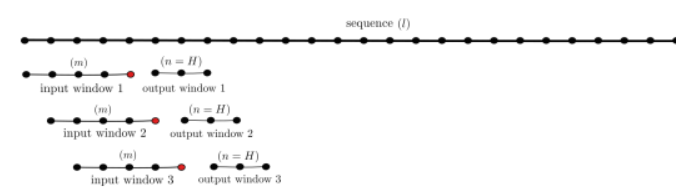


* As a preprocessing step, they transform the past observations of time series (Xi) into multiple pairs of input and output frames using a Moving Window (MW) strategy. Later, these frames are used as the
primary training source of LSTM-MSNet
* In summary, the MW strategy converts a time series Xi of length K into (K − n − m) records, where each record has an amount of (m + n) observations. 
* Here, m refers to the length of the output window (Forecast Period), and n is the length of the input window (Look back Period). 
*These frames are generated according to the Multi-Input Multi-Output (MIMO) principle used in multi-step forecasting, which directly predicts all the future observations up to the intended forecasting horizon.
* The input window or the Lookback Period = n* output window or Forecast Period, with n being 1.5 in the paper. Example for understanding MIMO is:

In [ ]:
def sliding_window(series, in_len,out_len, stride=1):
    x = []
    y = []
    
    #from zero to the last possible index
    for i in range(0, len(series) -(in_len+out_len-1), stride):
				#is taking out chunks of sequence length
        #if for ex I take in length 3 and out_len 2, I take the first three rows as an input the next two rows as an output
        #then append them to a list and concatenate later
				
        x.append(np.expand_dims(series[i:i+in_len],  axis=0))
        y.append(np.expand_dims(series[i+in_len:i + (in_len+out_len)], axis=0))
    #x becomes a sequence of arrays on the axis=0
    x = np.concatenate(x, axis=0)
    y = np.concatenate(y, axis=0)
    return x, y

result_x,result_y = sliding_window( deseasonalized_df.iloc[:700,1:].values, 60,48, stride=1)

### Training Paradigms

This study propose to use
the output of the decomposition layer in two different ways.
These paradigms can be distinguished by the time series
components used in the Moving window process,

* Deseasonalised Approach (DS)  : 

This approach uses
seasonally adjusted time series as MW patches to train the
LSTM-MSNet. Since the seasonal components are not included in DS for the training procedure, a reseasonalisation
technique is later introduced in the Post-processing layer of
LSTM-MSNet to ascertain the corresponding multiple seasonal components of the time series.

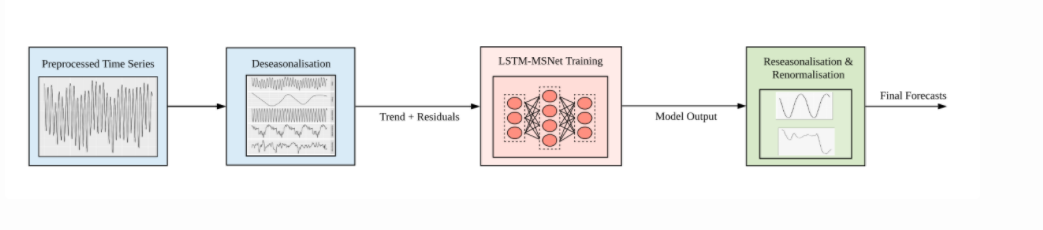

* Seasonal Exogenous Approach (SE): 

This second approach uses the output of the pre-processing layer, together with the seasonal components extracted from the multi seasonal decomposition as external variables. As the original components of the time series are used in the training phase of SE, the LSTM-MSNet is expected to forecast all the components of a time series,
including the relevant multi-seasonal patterns. Therefore, a reseasonalisation stage is not required by SE

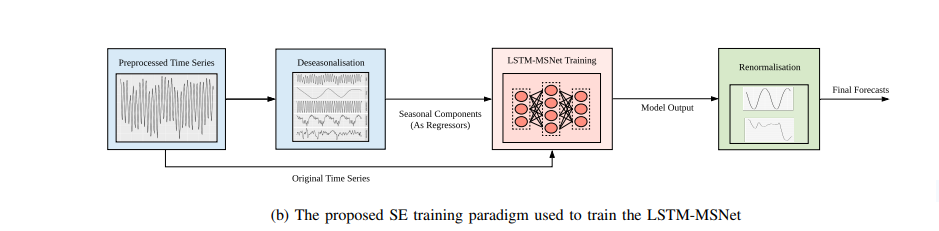

In summary, 
* DS supplements the LSTM-MSNet by excluding the seasonal factors in the LSTM-MSNet training
procedure. This essentially minimises the overall training
complexity of the LSTM-MSNet. 
* In contrast, SE supplements
LSTM-MSNet in the form of exogenous variables that assist
modelling the seasonal trajectories of a time series

## Deseasonalised Approach (DS)

* The DS paradigm can be seen as a boosting ensemble
technique , where the deseasonalisation process is a weak
base learner that is subsequently supplemented by the LSTM,
which is trained on the remainder of the base learner. 
* Here,
the complexity of the base learner, i.e., the different deseasonalisation techniques, can affect the subsequent LSTM training
procedure and may lead to different results.

### LSTM Learning Scheme

* As highlighted earlier, we use
the past observations of time series Xi
, in the form of input
and output windows( generated using Moving Window strategy) to train the LSTM-MSNet. 

* Fig.  illustrates the primary LSTM
learning architecture of LSTM-MSNet. This consists of four
components, namely: Training input window layer, LSTM
stacking layer, Dense layer and Training output window layer.


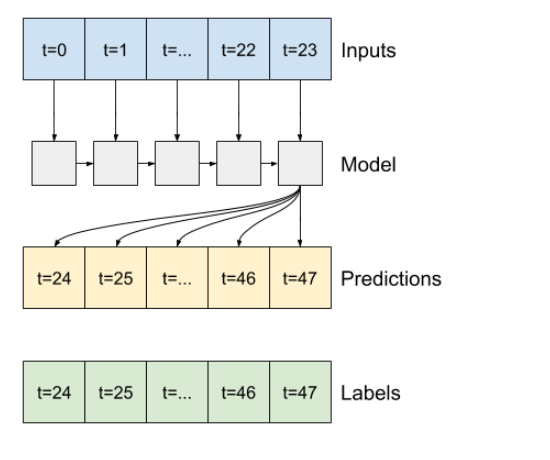

In [ ]:
class MS_LSTM(torch.nn.Module):
    def __init__(self,n_features,seq_length):
        super(MS_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_len = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)
    
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        
        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, n_features*48)
        
    
    def init_hidden(self, batch_size):
        
        if(train_on_gpu):
          hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).cuda()
          cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).cuda()
          self.hidden = (hidden_state, cell_state)

        else:
          hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
          cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden)
          self.hidden = (hidden_state, cell_state)
    
    
    
    def forward(self, x):        
        batch_size, seq_len,_ = x.size()
        #print("batch_size ", batch_size,"seq_len ", seq_len)
        
        lstm_out, _ = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        #print(lstm_out.size())
        x = self.l_linear(x)
        return x.view(-1,n_features)

#### Local Normalization

* Before feeding these windows to the network for training,
each input and output window is subjected to a local normalisation process to avoid possible network saturation effects
caused by the bounds of the network activation functions.
*  In the DS approach, we use the trend component of
the last value of the input window as a local normalisation
factor.

* These factors
are subtracted from each data point in the corresponding input
and output window


In [ ]:


## Local normalization on training data
train_x = []
train_y = []
for i in range(0,len(result_x)):
  train_x.append(torch.FloatTensor(result_x[i] - trend_df.iloc[i+59,1:][None,:]))
  train_y.append(torch.FloatTensor(result_y[i] - trend_df.iloc[i+59,1:][None,:]))

# localization on last 60 rows of training data as test input
test_x = torch.FloatTensor(deseasonalized_df.iloc[640:700,1:].to_numpy() - trend_df.iloc[699, 1:][None,:])



#### Loss Function
 * The L1-norm, as the primary
learning objective function, which essentially minimises the absolute differences between the target values and the estimated values. 

* The L1-loss is given by:




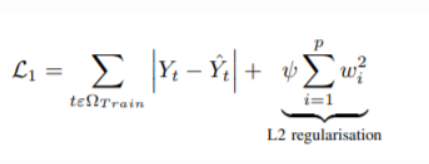

Here, Yt ∈ R
m refers to the actual observations of values in
the output window at time step t. The cell output of the LSTM
at time step t is defined by Yˆ
t. Also, ΩT rain is the set of time
steps used for training. We include an L2-regularisation term to
minimise possible overfitting of the network.

In [ ]:
n_features = 414 # this is number of parallel inputs
n_timesteps = 60 # this is number of timesteps

# create NN
ms_net = MS_LSTM(n_features,n_timesteps)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(ms_net.parameters(), lr=1e-4 , weight_decay=1e-6) # weight decay is l2 regulariztion

train_episodes = 65
batch_size = 1
print(ms_net)

MS_LSTM(
  (l_lstm): LSTM(414, 20, batch_first=True)
  (l_linear): Linear(in_features=1200, out_features=19872, bias=True)
)


In [ ]:
# model training

# move model to GPU, if available
if(train_on_gpu):
      ms_net.cuda()
for t in range(train_episodes):
    for b in range(0,len(train_x),batch_size):
        
        ms_net.init_hidden(1)
    
        if(train_on_gpu):
          train_x[b], train_y[b] = train_x[b].cuda(), train_y[b].cuda()
        output = ms_net(train_x[b].unsqueeze(0))
        #print(output.size)
        #print(train_y[b].size())
        
        loss = criterion(output, train_y[b])
        loss.backward()
        optimizer.step()        
        optimizer.zero_grad() 
        
    print('step : ' , t , 'loss : ' , loss.item())

In [ ]:
#torch.save(ms_net, "/content/drive/My Drive/Colab Notebooks/model.pth")
#https://drive.google.com/file/d/10Vb0Fbp2xe4UI0nnClLflWG9eVsiYIQn/view?usp=sharing
msnet = torch.load("/content/drive/My Drive/Colab Notebooks/model.pth")


In [ ]:
ms_net.eval()
eval_out = []
with torch.no_grad():
      if train_on_gpu:
          ms_net.hidden = (torch.zeros(1, 1, ms_net.n_hidden).cuda(),torch.zeros(1, 1, ms_net.n_hidden).cuda())
      else:
          ms_net.hidden = (torch.zeros(1, 1, ms_net.n_hidden),torch.zeros(1, 1, ms_net.n_hidden))
      eval_out.append(ms_net(train_x[0].unsqueeze(0)))

In [ ]:
if train_on_gpu:
  train_y_hat = pd.DataFrame(eval_out[0].cpu(), columns = data.columns)
  train_y_ = pd.DataFrame(train_y[0].cpu(), columns = data.columns)
else:
  train_y_hat = pd.DataFrame(eval_out[0], columns = data.columns)
  train_y_ = pd.DataFrame(train_y[0], columns = data.columns)

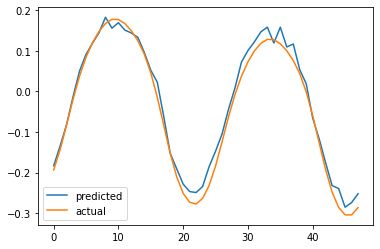

In [ ]:
plt.plot(train_y_hat['H121'], label = 'predicted')
plt.plot(train_y_['H121'], label = 'actual')
plt.legend()
plt.show()

## Post-Processing Layer

* The reseasonalisation and renormalisation is the main component of the post processing layer in LSTM-MSNet. 

* In
the reseasonalisation stage, the relevant seasonal components
of the time series are added to the forecasts generated by the LSTM. This is computed by repeating the last seasonal
components of the time series to the intended forecast horizon.

* Next, in the renormalisation phase, the generated forecasts
are back-transformed to their original scale by adding back
the corresponding local normalisation factor, and taking the
exponent of the values. 
* The final forecasts are obtained by
multiplying this vector by the scaling factor used for the
normalisation process.




In [ ]:
y = pd.DataFrame(data.iloc[0:107,:]) 

In [ ]:
#adding back seasonality for first traget window,
train_y_hat = train_y_hat.values + seasonality_df.iloc[60:108, 1:]

# adding the trend component of the last value of the input window( 60th row ) for first train window
train_y_hat = train_y_hat + trend_df.iloc[59,1:][None,:]
train_y_hat = np.exp(train_y_hat) 


# multiplying by the scaling factor( mean of time series)
train_y_hat = train_y_hat * (data.sum(axis=0)/700).to_numpy()
train_y_hat = pd.DataFrame(train_y_hat , columns= data.columns)

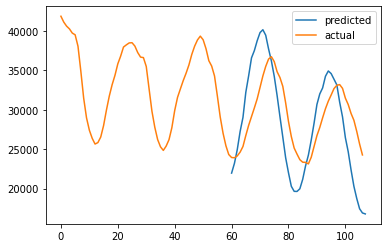

In [ ]:
plt.plot(train_y_hat['H11'], label = 'predicted')
plt.plot(y['H11'], label = 'actual')
plt.legend()
plt.show()

## Evaluation on Test Data

In [ ]:
eval_out = []
with torch.no_grad():
    if train_on_gpu:
          # initializing Hidden Layer
          ms_net.hidden = (torch.zeros(1, 1, ms_net.n_hidden).cuda(),torch.zeros(1, 1, ms_net.n_hidden).cuda())
    else:
          ms_net.hidden = (torch.zeros(1, 1, mv_net.n_hidden),torch.zeros(1, 1, ms_net.n_hidden))
    # passing last 60 rows of training data as test input
    eval_out.append(ms_net(test_x.unsqueeze(0).cuda()))

In [ ]:
test_y_hat = pd.DataFrame(eval_out[0].cpu().numpy(), columns = data.columns[:])


In [ ]:

# adding the trend component of the last value of the input window( 60th row ) for first test window
test_y_hat = test_y_hat + trend_df.iloc[699,1:][None,:]
test_y_hat = np.exp(test_y_hat) 


# multiplying by the scaling factor( mean of time series)
test_y_hat = test_y_hat * (data.sum(axis=0)/700).to_numpy()
test_y_hat = pd.DataFrame(test_y_hat , columns= data.columns)

In [ ]:
#https://www.kaggle.com/yogesh94/m4-forecasting-competition-dataset?select=Hourly-test.csv
test_y_ =load_data('/content/drive/My Drive/Hourly-test.csv',100)


Comparative plot of Actual and Predicted values of Test Data

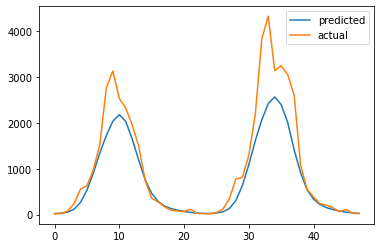

In [ ]:
# plotting predicted values from the model
plt.plot(test_y_hat['H125'], label = 'predicted')
# plotting actual values from test dataset provided
plt.plot(test_y_['H125'] , label = 'actual')
plt.legend()
plt.show()

## Error Metrics

* Symmetric Mean Absolute
Percentage Error (sMAPE) 
* The Mean Absolute Scaled
Error (MASE). 
*The sMAPE and MASE are defined as
follows:


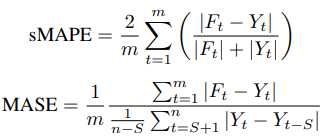

Here, Yt represents the observation at time t, and Ft is the
generated forecast. Also, m denotes the number of data points
in the test set and n is the number of observations in the
training set of a time series. For M4 dataset s is 168.

In [ ]:
def smape_loss(y_pred, y_true):
    denominator = (np.abs(y_true) + np.abs(y_pred)) 
    diff = np.abs(y_true - y_pred) / denominator
    diff = 2/48.0 *(diff.sum())
    return diff

In [ ]:
def mase_loss(y_pred, y_true, y_test):
    s = 0.0
    for i in range(169,700):
      s= s+ np.abs(y_test.iloc[i] -y_test.iloc[i-168])
      
    # 700-168 = 532  
    s = s/532.0
    diff = np.abs(y_true - y_pred).sum()
    diff = (diff/s)/48.0
    return diff

In [ ]:
sMAPE = []
MASE = []
for col in test_y_hat.columns[1:]:
  smape = smape_loss(test_y_hat[col],test_y_[col])
  mase = mase_loss(test_y_hat[col],test_y_[col],data[col]) 
  sMAPE.append(smape)
  MASE.append(mase)

In [ ]:
Median_sMAPE = np.median(sMAPE)
Median_MASE = np.median(MASE)

In [ ]:
Median_sMAPE

0.18321789267252842

In [ ]:
Median_MASE

2.2533282236404792

In [ ]:
Mean_sMAPE = np.mean(sMAPE)
Mean_MASE = np.mean(MASE)



In [ ]:
Mean_sMAPE

0.268145088775241

In [ ]:
# having outlier 
Mean_MASE

2.7272369984749476